In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


In [27]:

# --- Data Loading and Preprocessing ---

data = pd.read_csv('aggregated_data.csv')
test_data = pd.read_csv('aggregated_data_test.csv')


data.dropna(inplace=True)  # Handle missing values

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209396 entries, 0 to 209395
Data columns (total 49 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   HH_ID                                             209396 non-null  object 
 1   Sector                                            209396 non-null  int64  
 2   State                                             209396 non-null  int64  
 3   NSS-Region                                        209396 non-null  int64  
 4   District                                          209396 non-null  int64  
 5   Household Type                                    209396 non-null  int64  
 6   Religion of the head of the household             209396 non-null  int64  
 7   Social Group of the head of the household         209396 non-null  int64  
 8   HH Size (For FDQ)                                 209396 non-null  int64  
 9   NCO_

In [29]:
target = 'TotalExpense'

# y = data[target]
# X = data.drop(columns=[target,"HH_ID"])

X_train = data.drop(columns=[target,"HH_ID"])
y_train = data[target]

X_test = test_data.drop(columns=[target,"HH_ID"])
y_test = test_data[target]

In [30]:
# apply log to target
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [31]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# --- Linear Regression Model ---

# Create a pipeline:  Preprocessing (scaling) + Linear Regression
model = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling (standardization)
    ('linear_regression', LinearRegression())
])


In [33]:
# --- Cross-Validation ---
# Perform cross-validation to assess model performance more reliably.
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')  # 5-fold CV
rmse_scores = np.sqrt(-cv_scores)  # Convert negative MSE to RMSE

print(f"Cross-Validation RMSE Scores: {rmse_scores}")
print(f"Mean CV RMSE: {rmse_scores.mean()}")
print(f"Standard Deviation of CV RMSE: {rmse_scores.std()}")


Cross-Validation RMSE Scores: [10337.19293671  9651.89283989  9689.42186082 10616.20006453
  9621.51790454]
Mean CV RMSE: 9983.245121299531
Standard Deviation of CV RMSE: 413.0094522727651


In [34]:
# --- Training on the Full Training Set ---
model.fit(X_train, y_train_log)

# --- Prediction and Evaluation ---
y_pred = model.predict(X_test)

In [35]:
mse = mean_squared_error(y_test, np.exp(y_pred))
rmse = np.sqrt(mse)
r2 = r2_score(y_test, np.exp(y_pred))
mape = mean_absolute_percentage_error(y_test, np.exp(y_pred))

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")


Mean Squared Error (MSE): 103144528.4345592
Root Mean Squared Error (RMSE): 10156.009473930162
R-squared (R2): 0.4459054831968541
Mean Absolute Percentage Error (MAPE): 0.29703033459170797


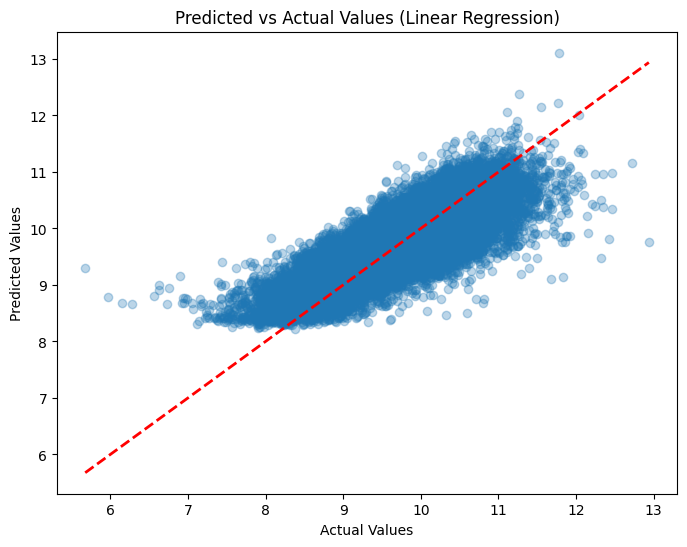


Feature Importance (Coefficients):
                                             Feature  Coefficient  \
2                                         NSS-Region    -2.969413   
1                                              State     2.950421   
7                                  HH Size (For FDQ)     0.200667   
30                           Is_HH_Have_Refrigerator     0.070589   
24                         Is_HH_Have_Mobile_handset     0.069384   
38                                          mean_age    -0.064927   
27                      Is_HH_Have_Motorcar_jeep_van     0.060055   
40                                     max_education     0.059387   
26                     Is_HH_Have_Motorcycle_scooter     0.057897   
37                                     count_females    -0.048903   
21                             Is_HH_Have_Television     0.045641   
0                                             Sector     0.043259   
41                              count_internet_users     0.043000  

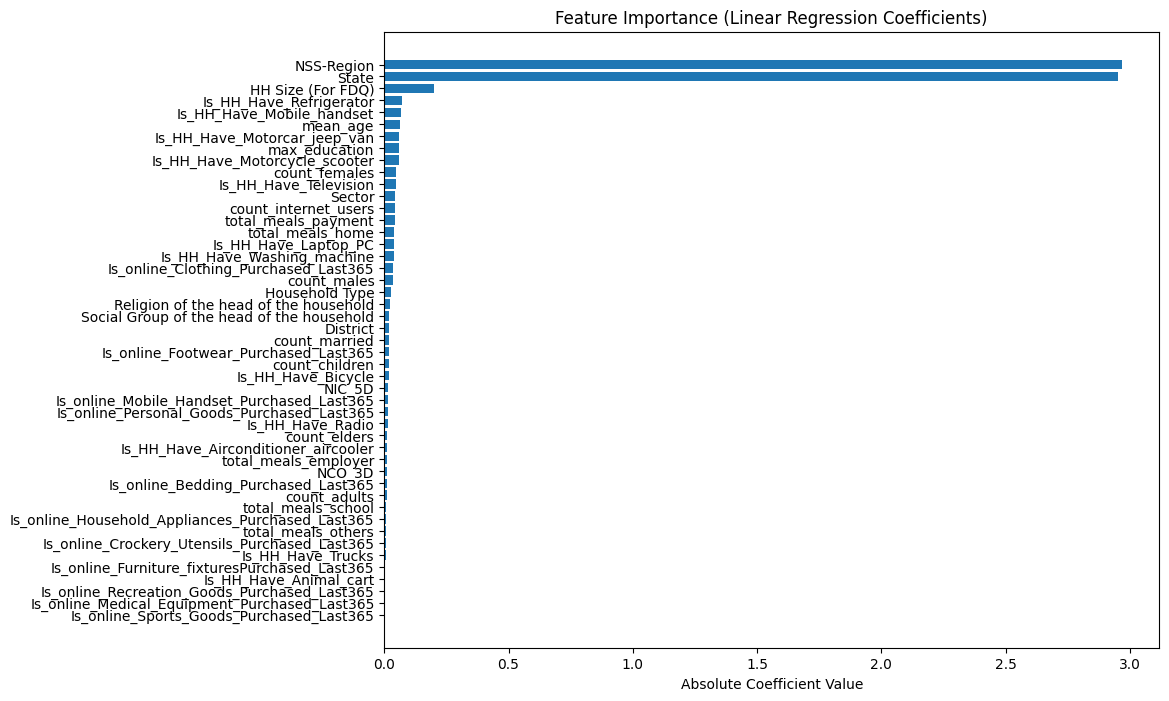

In [24]:
# --- Plotting Predicted vs Actual Values ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Ideal prediction line
plt.title('Predicted vs Actual Values (Linear Regression)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# --- Feature Importance (Coefficients) ---
# Get the coefficients of the linear regression model
coefficients = model.named_steps['linear_regression'].coef_
feature_names = X_train.columns

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])  # Absolute values
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

print("\nFeature Importance (Coefficients):")
print(feature_importance)

# --- Plotting Feature Importance ---

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Abs_Coefficient'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance (Linear Regression Coefficients)')
plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
plt.show()



In [25]:

# --- Optional: Polynomial Features ---
#  If you suspect non-linear relationships, try adding polynomial features.

# Example:  Add polynomial features of degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)  # degree=2 creates quadratic features
model_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', poly),
    ('linear_regression', LinearRegression())
])

# Cross-validation with polynomial features
cv_scores_poly = cross_val_score(model_poly, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores_poly = np.sqrt(-cv_scores_poly)

print(f"\nCross-Validation RMSE Scores (Polynomial Features): {rmse_scores_poly}")
print(f"Mean CV RMSE (Polynomial Features): {rmse_scores_poly.mean()}")

# Train and evaluate (polynomial features)
model_poly.fit(X_train, y_train)
y_pred_poly = model_poly.predict(X_test)

mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test, y_pred_poly)
mape_poly = mean_absolute_percentage_error(y_test, y_pred_poly)

print(f"\nPolynomial Regression (Degree=2):")
print(f"  MSE: {mse_poly}")
print(f"  RMSE: {rmse_poly}")
print(f"  R-squared: {r2_poly}")
print(f"  MAPE: {mape_poly}")

# Feature importance is more complex with polynomial features, as each feature
# now has multiple terms.  You could sum the absolute coefficients for all
# terms related to a single original feature, but interpretation is less
# straightforward than with simple linear regression.


Cross-Validation RMSE Scores (Polynomial Features): [0.34617477 0.34578222 0.35623805 0.34563599 0.34543421]
Mean CV RMSE (Polynomial Features): 0.3478530487332479

Polynomial Regression (Degree=2):
  MSE: 0.12073731745921766
  RMSE: 0.34747275786630766
  R-squared: 0.6541001948566496
  MAPE: 0.02759550943904831
